# Base

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
import pylab as plt
import json
import random
import math
import vit_pytorch
import einops
import copy
from munch import Munch
import h5py
import re
from functools import reduce

In [12]:
checkpoints_root = '/root/project/checkpoints'
metric_names = sorted(['acc1', 'acc0', 'acc', 'ap', 'auc', 'f1', 'recall', 'recall_at_3s', 'mIoU', 'train_loss', 'val_loss', 'mAP'])

In [13]:
def load_scores(names, stage='finetune'):
    result = {metric_name:{name:[] for name in names} for metric_name in metric_names}
    for name in names:
        log_file_list = []
        for file_name in os.listdir(os.path.join(checkpoints_root, name)):
            if file_name.endswith('.log') and file_name.startswith(stage):
                log_file_list.append(file_name)
        if len(log_file_list)==0: continue
        log_file_list.sort()
        log_file = os.path.join(checkpoints_root, name, log_file_list[-1])
        
        with open(log_file) as f:
            lines = f.readlines()
        for line in lines:
            for metric_name in metric_names:
                if re.match(f'^{metric_name} : ', line):
                    # value = float(re.search(r'-?\d+\.?\d*e?-?\d*?', line[len(metric_name)+3:]).group())
                    value = float(line.split(':')[-1].strip())
                    result[metric_name][name].append(value)
    return result

# Statistic metrics

## best

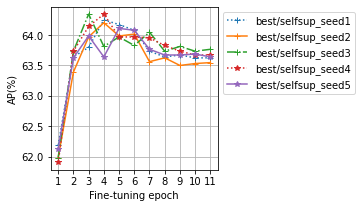

In [4]:
plt.figure(figsize=(3,3))
kws=[':+','-+','-.+',':*','-*','-.*']
method_names = [f'selfsup_seed{n}' for n in range(1,6)]
mean_log = []
legend_names = method_names
for i,method in enumerate(method_names):
    names = [method]
    scores = load_scores(names, 'finetune')
    x = np.array(list(scores['mAP'].values()))
    if x.size == 0: continue
    mean, std = x.mean(0), x.std(0)
    mean_log.append((np.argmax(mean), max(mean)))
    plt.plot(mean, kws[i%len(kws)])
plt.legend(legend_names, bbox_to_anchor=(1,1))
# plt.legend(legend_names)
plt.ylabel('AP(%)')
plt.xlabel('Fine-tuning epoch')
plt.xticks(range(0,11), range(1,12))
plt.grid()

In [5]:
scores = load_scores(method_names, 'finetune')
df = pd.DataFrame(scores).applymap(lambda x:x[-1] if len(x) else None)
df.sort_values('mAP').round(2)

,acc,acc0,acc1,ap,auc,f1,mAP,mIoU,recall,recall_at_3s,train_loss,val_loss
best/selfsup_seed2,91.10,92.52,73.60,62.56,92.72,55.40,63.55,56.41,75.29,79.54,0.18,0.67
best/selfsup_seed1,90.99,92.36,74.07,62.46,92.72,55.25,63.62,56.31,75.71,79.87,0.18,0.64
best/selfsup_seed5,91.13,92.56,73.51,62.47,92.74,55.44,63.64,56.42,75.22,79.36,0.17,0.67
best/selfsup_seed4,90.96,92.34,73.96,62.66,92.76,55.12,63.67,56.22,75.59,79.71,0.17,0.65
best/selfsup_seed3,91.03,92.44,73.76,62.53,92.69,55.26,63.77,56.39,75.52,79.56,0.17,0.66


In [6]:
df.mean(), df.std()

(acc             91.042342
 acc0            92.443513
 acc1            73.781961
 ap              62.537075
 auc             92.726276
 f1              55.295471
 mAP             63.650000
 mIoU            56.350543
 recall          75.465687
 recall_at_3s    79.606871
 train_loss       0.174812
 val_loss         0.658804
 dtype: float64,
 acc             0.071537
 acc0            0.095477
 acc1            0.235082
 ap              0.083587
 auc             0.025842
 f1              0.126478
 mAP             0.079365
 mIoU            0.086220
 recall          0.204500
 recall_at_3s    0.190927
 train_loss      0.000521
 val_loss        0.012751
 dtype: float64)

## light version

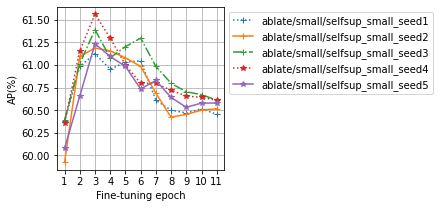

In [12]:
plt.figure(figsize=(3,3))
kws=[':+','-+','-.+',':*','-*','-.*']
method_names = [f'selfsup_light_seed{n}' for n in range(1,6)]
mean_log = []
legend_names = method_names
for i,method in enumerate(method_names):
    names = [method]
    scores = load_scores(names, 'finetune')
    x = np.array(list(scores['mAP'].values()))
    if x.size == 0: continue
    mean, std = x.mean(0), x.std(0)
    mean_log.append((np.argmax(mean), max(mean)))
    plt.plot(mean, kws[i%len(kws)])
plt.legend(legend_names, bbox_to_anchor=(1,1))
# plt.legend(legend_names)
plt.ylabel('AP(%)')
plt.xlabel('Fine-tuning epoch')
plt.xticks(range(0,11), range(1,12))
plt.grid()

In [13]:
scores = load_scores(method_names, 'finetune')
df = pd.DataFrame(scores).applymap(lambda x:x[-1] if len(x) else None)
df.sort_values('mAP').round(2)

,acc,acc0,acc1,ap,auc,f1,mAP,mIoU,recall,recall_at_3s,train_loss,val_loss
ablate/small/selfsup_small_seed1,90.67,92.30,70.50,59.55,91.56,53.15,60.45,54.78,72.13,77.05,0.22,0.51
ablate/small/selfsup_small_seed2,90.79,92.43,70.61,59.67,91.55,53.51,60.52,55.11,72.28,77.13,0.22,0.51
ablate/small/selfsup_small_seed5,90.91,92.58,70.32,59.62,91.52,53.74,60.58,55.13,71.94,76.81,0.22,0.52
ablate/small/selfsup_small_seed3,90.93,92.61,70.26,59.83,91.54,53.78,60.61,55.17,71.96,76.71,0.22,0.52
ablate/small/selfsup_small_seed4,90.62,92.21,70.93,59.85,91.57,53.16,60.61,54.75,72.53,77.35,0.22,0.51


In [14]:
df.mean(), df.std()

(acc             90.783116
 acc0            92.427609
 acc1            70.525378
 ap              59.703928
 auc             91.549200
 f1              53.469688
 mAP             60.553125
 mIoU            54.987498
 recall          72.169521
 recall_at_3s    77.010485
 train_loss       0.220017
 val_loss         0.511126
 dtype: float64,
 acc             0.141840
 acc0            0.172457
 acc1            0.267897
 ap              0.127954
 auc             0.017808
 f1              0.305090
 mAP             0.067748
 mIoU            0.205581
 recall          0.244423
 recall_at_3s    0.258689
 train_loss      0.000896
 val_loss        0.005808
 dtype: float64)

# Clip_len

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


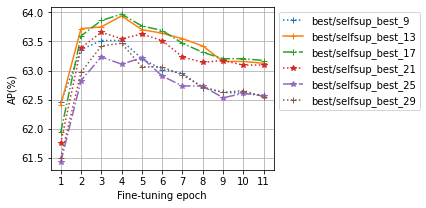

In [14]:
plt.figure(figsize=(4,3))
kws=[':+','-+','-.+',':*','-*','-.*']
method_names = [f'best/selfsup_best_{n}' for n in range(9,34,4)]
mean_log = []
legend_names = method_names
for i,method in enumerate(method_names):
    names = [method]
    scores = load_scores(names, 'finetune')
    x = np.array(list(scores['mAP'].values()))
    if x.size == 0: continue
    mean, std = x.mean(0), x.std(0)
    mean_log.append((np.argmax(mean), max(mean)))
    plt.plot(mean, kws[i%len(kws)])
plt.legend(legend_names, bbox_to_anchor=(1,1))
# plt.legend(legend_names)
plt.ylabel('AP(%)')
plt.xlabel('Fine-tuning epoch')
plt.xticks(range(0,11), range(1,12))
plt.grid()

In [15]:
scores = load_scores(method_names, 'finetune')
df = pd.DataFrame(scores).applymap(lambda x:x[-1] if len(x) else None)
df.sort_values('mAP').round(2)

,acc,acc0,acc1,ap,auc,f1,mAP,mIoU,recall,recall_at_3s,train_loss,val_loss
best/selfsup_best_33,90.33,91.61,74.55,61.19,92.40,53.60,62.55,55.33,75.98,79.99,0.17,0.68
best/selfsup_best_29,90.67,92.00,74.28,61.33,92.47,54.42,62.56,55.93,75.55,79.99,0.17,0.76
best/selfsup_best_9,89.41,90.42,77.07,61.77,92.48,52.37,62.58,54.99,78.45,82.72,0.19,0.58
best/selfsup_best_21,90.43,91.66,75.35,61.82,92.57,54.19,63.09,55.77,76.75,81.11,0.17,0.64
best/selfsup_best_13,90.10,91.24,76.02,62.25,92.62,53.64,63.12,55.61,77.39,81.61,0.18,0.63
best/selfsup_best_17,90.98,92.39,73.65,62.21,92.75,55.12,63.17,56.38,74.93,78.95,0.17,0.68
best/selfsup_best_25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


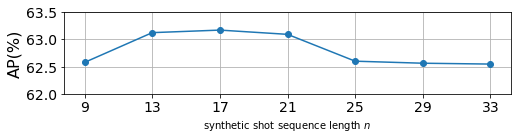

In [18]:
plt.figure(figsize=(8,1.5))
clip_len = list(range(9,34,4))
plt.plot(df['mAP'], '-o')
plt.grid()
plt.ylim(62,63.5)
plt.xticks(range(len(clip_len)), clip_len,fontsize=14)
plt.yticks([62,62.5,63,63.5],fontsize=14)
plt.xlabel('synthetic shot sequence length $n$')
plt.ylabel('AP(%)', fontdict={'fontsize':16})

plt.savefig('AP_length_work2.png', bbox_inches='tight')

# Less label

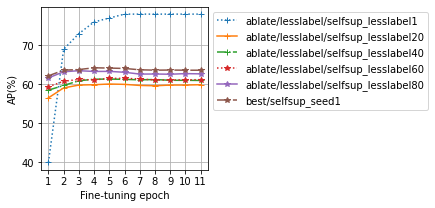

In [35]:
plt.figure(figsize=(3,3))
kws=[':+','-+','-.+',':*','-*','-.*']
method_names = ['selfsup_lesslabel'+str(s) for s in [1]+list(range(20,100,20))]+['selfsup_seed1']
mean_log = []
legend_names = method_names
for i,method in enumerate(method_names):
    names = [method]
    scores = load_scores(names, 'finetune')
    x = np.array(list(scores['mAP'].values()))
    if x.size == 0: continue
    mean, std = x.mean(0), x.std(0)
    mean_log.append((np.argmax(mean), max(mean)))
    plt.plot(mean, kws[i%len(kws)])
plt.legend(legend_names, bbox_to_anchor=(1,1))
# plt.legend(legend_names)
plt.ylabel('AP(%)')
plt.xlabel('Fine-tuning epoch')
plt.xticks(range(0,11), range(1,12))
plt.grid()

In [36]:
scores = load_scores(method_names, 'evaluate')
df = pd.DataFrame(scores).applymap(lambda x:x[-1] if len(x) else None)
df.sort_values('mAP').round(2)

,acc,acc0,acc1,ap,auc,f1,mAP,mIoU,recall,recall_at_3s,train_loss,val_loss
ablate/lesslabel/selfsup_lesslabel1,86.50,87.77,70.87,49.61,87.42,44.08,52.64,48.24,73.68,78.13,None,0.46
ablate/lesslabel/selfsup_lesslabel20,91.55,93.43,68.34,59.64,91.65,54.84,60.84,55.82,70.07,74.78,None,0.78
ablate/lesslabel/selfsup_lesslabel40,91.53,93.26,70.22,61.56,92.10,55.44,62.56,56.38,72.07,76.14,None,0.78
ablate/lesslabel/selfsup_lesslabel60,91.39,93.03,71.12,61.54,92.23,55.36,62.64,56.43,72.92,77.07,None,0.76
ablate/lesslabel/selfsup_lesslabel80,91.17,92.69,72.41,61.78,92.41,55.19,62.70,56.07,74.03,78.44,None,0.73
best/selfsup_seed1,90.99,92.36,74.07,62.46,92.72,55.25,63.62,56.31,75.71,79.87,None,0.67


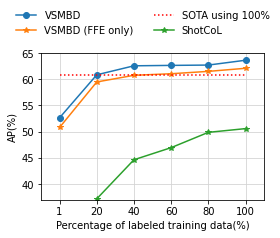

In [29]:
plt.figure(figsize=(4.,2.7))
clip_len = [1]+list(range(20,101,20))
# plt.plot(df['mAP'], '-o')
plt.plot(list(df['mAP']), '-o')
plt.grid(color='lightgrey')
plt.ylim(37,65)
plt.xticks(range(len(clip_len)), clip_len)
plt.xlabel('Percentage of labeled training data(%)')
plt.ylabel('AP(%)')
plt.xlim(-.5,len(clip_len)-.5)

# VSMBD (FFE only)
plt.plot([50.80, 59.48, 60.75, 61.05, 61.50, 62.09], '-*')

# # DTW-based (FFE only)
# plt.plot([11.0, 48.45, 50.17, 52.04, 56.92, 57.48], '-*')

# sota
plt.plot([0,len(clip_len)-1],[60.78]*2, 'r:')

# ShotCoL
plt.plot([8.0, 37.18, 44.64, 46.95, 49.87, 50.58], '-*')

# plt.bar([len(clip_len)-1],[60.78])
# plt.bar([len(clip_len)-1],[57.4])
# plt.bar([len(clip_len)-1],[54.55])
# plt.bar([len(clip_len)-1],[53.4])

# plt.legend(['SynBD (Ours)', 'ShotCoL', 'SCRL', 'BaSSL', 'TranS4mer'], loc='lower right')#bbox_to_anchor=(.6,.9))
# plt.legend(['SynBD (Ours)', 'SynBD (FFE only)', 'SOTA using 100%', 'DTW-based (FFE only)'], loc='upper center', bbox_to_anchor=(.5,1.4))
# plt.legend(['SynBD (Ours)', 'SynBD (FFE only)', 'DTW-based (FFE only)', 'SOTA using 100%'], loc='lower right', bbox_to_anchor=(2.1,0))
# plt.legend(['SynBD', 'SynBD (FFE only)', 'SOTA using 100%'])#, loc='lower right')#, bbox_to_anchor=(2.1,0))
# plt.legend(['VSMBD', 'VSMBD (FFE only)', 'SOTA using 100%', 'ShotCoL'], loc='lower right', bbox_to_anchor=(1.95,0))
plt.legend(['VSMBD', 'VSMBD (FFE only)', 'SOTA using 100%', 'ShotCoL'], \
           loc='upper left', ncol=2, bbox_to_anchor=(-.15,1.35), frameon=False)

plt.savefig('lesslabel.pdf', bbox_inches='tight')

# Clip_len for STD

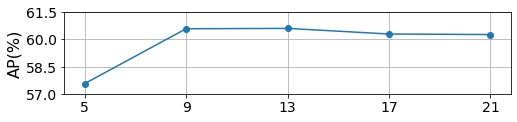

In [10]:
plt.figure(figsize=(8,1.5))
clip_len = list(range(5,22,4))
plt.plot([57.56, 60.59, 60.61, 60.30, 60.27], '-o')
plt.grid()
# plt.ylim(60,63)
plt.yticks([57,58.5,60, 61.5],fontsize=14)
plt.xticks(range(5),clip_len,fontsize=14)
# plt.xlabel()
plt.ylabel('AP(%)', fontdict={'fontsize':16})

plt.savefig('AP_length_work1.png', bbox_inches='tight')